#Add Libraries

In [ ]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn imbalanced-learn joblib

import time
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
#Remove skilit Warnings
warnings.filterwarnings("ignore")

#Import Data

In [44]:
#upload dataset
from google.colab import files
uploaded = files.upload()

Saving short_data.csv to short_data.csv


In [45]:
#import dataset
df_raw=pd.read_csv("short_data.csv")

#Preprocessing

Text(0.5, 1.0, 'Before Preprocessing - z-axis')

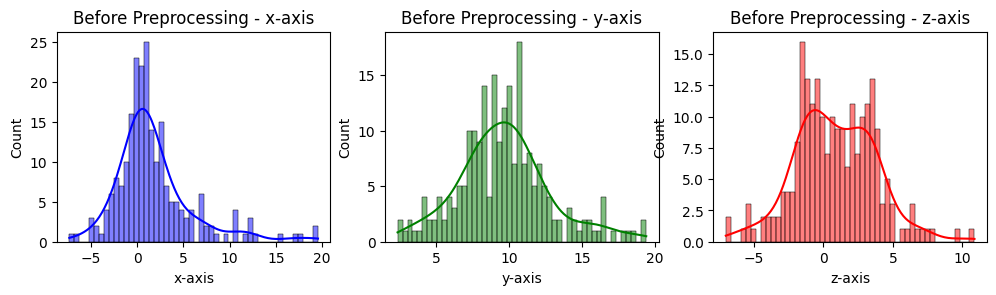

In [46]:
#Get Graph Before Preprocessing
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
sns.histplot(df_raw["x-axis"], kde=True, color='blue', bins=50)
plt.title("Before Preprocessing - x-axis")

plt.subplot(2, 3, 2)
sns.histplot(df_raw["y-axis"], kde=True, color='green', bins=50)
plt.title("Before Preprocessing - y-axis")

plt.subplot(2, 3, 3)
sns.histplot(df_raw["z-axis"], kde=True, color='red', bins=50)
plt.title("Before Preprocessing - z-axis")


In [47]:
#Preprocessing Data (filling Null,removing duplicates,sorting records)
df = df_raw.fillna(df_raw.select_dtypes(include='number').mean())
df = df.drop_duplicates(subset='timestamp', keep='first')
df = df.sort_values("timestamp")

In [48]:
#Encoding Label 'activities'
le=LabelEncoder()
df["activity"]=le.fit_transform(df["activity"])

In [49]:
#Set Role
#Tree And RF features
x = df[['timestamp',"x-axis","y-axis","z-axis"]]
y=df["activity"]

In [50]:
#Feature Engineering For KNN
df["sq_acc"]=df["x-axis"]**2+df["y-axis"]**2+df["z-axis"]**2

df['x-axis_mean'] = df['x-axis'].rolling(window=3).mean()
df['x-axis_std'] = df['x-axis'].rolling(window=3).std()
df["x-axis_mean"]=df["x-axis_mean"].fillna(df["x-axis_mean"].mean())
df["x-axis_std"]=df["x-axis_std"].fillna(df["x-axis_std"].mean())

df['y-axis_mean'] = df['y-axis'].rolling(window=3).mean()
df['y-axis_std'] = df['y-axis'].rolling(window=3).std()
df["y-axis_mean"]=df["y-axis_mean"].fillna(df["y-axis_mean"].mean())
df["y-axis_std"]=df["y-axis_std"].fillna(df["y-axis_std"].mean())

df['z-axis_mean'] = df['z-axis'].rolling(window=3).mean()
df['z-axis_std'] = df['z-axis'].rolling(window=3).std()
df["z-axis_mean"]=df["z-axis_mean"].fillna(df["z-axis_mean"].mean())
df["z-axis_std"]=df["z-axis_std"].fillna(df["z-axis_std"].mean())

df['sq_mean'] = df['sq_acc'].rolling(window=3).mean()
df['sq_std'] = df['sq_acc'].rolling(window=3).std()
df["sq_mean"]=df["sq_mean"].fillna(df["sq_mean"].mean())
df["sq_std"]=df["sq_std"].fillna(df["sq_std"].mean())

df['x-axis_ema'] = df['x-axis'].ewm(span=3).mean()
df["x-axis_ema"]=df["x-axis_ema"].fillna(df["x-axis_ema"].mean())

df['y-axis_ema'] = df['y-axis'].ewm(span=3).mean()
df["z-axis_ema"]=df["y-axis_ema"].fillna(df["y-axis_ema"].mean())

df['z-axis_ema'] = df['z-axis'].ewm(span=3).mean()
df["z-axis_ema"]=df["z-axis_ema"].fillna(df["z-axis_ema"].mean())

knn_x=df[["timestamp","x-axis","y-axis","z-axis","sq_acc","x-axis_std","x-axis_mean","y-axis_std","y-axis_mean","z-axis_std","z-axis_mean","sq_mean","sq_std","x-axis_ema","y-axis_ema","z-axis_ema"]]

In [51]:
#Balancing Samples
sm=SMOTE(sampling_strategy='auto',random_state=42)
x_bal,y_bal=sm.fit_resample(x,y)

knn_sm=SMOTE(sampling_strategy='auto',random_state=42)
knn_x_bal,knn_y_bal=knn_sm.fit_resample(knn_x,y)

#Spliting Data

In [52]:
#Spliting Data into 70% (train) 30% (test)
x_train,x_test,y_train,y_test=train_test_split(x_bal,y_bal,test_size=0.3,random_state=42)
knn_x_train,knn_x_test,knn_y_train,knn_y_test=train_test_split(knn_x_bal,knn_y_bal,test_size=0.3,random_state=42)

In [53]:
#Safe Conversion For Graphs
if isinstance(x_train, pd.DataFrame):
    x_train = x_train.to_numpy()
x_train = np.nan_to_num(x_train)

#Normalization

In [54]:
#Normalization
knn_ss=MinMaxScaler()
knn_x_train=knn_ss.fit_transform(knn_x_train)
knn_x_test=knn_ss.transform(knn_x_test)

#Random Forest & Decision Tree Don't Need Normalization

#Graph after preprocessing

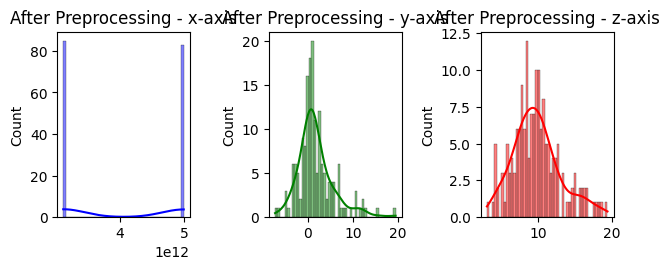

In [55]:
#After preprocessing
plt.subplot(2, 3, 4)
sns.histplot(x_train[:, 0], kde=True, color='blue', bins=50)
plt.title("After Preprocessing - x-axis")

plt.subplot(2, 3, 5)
sns.histplot(x_train[:, 1], kde=True, color='green', bins=50)
plt.title("After Preprocessing - y-axis")

plt.subplot(2, 3, 6)
sns.histplot(x_train[:, 2], kde=True, color='red', bins=50)
plt.title("After Preprocessing - z-axis")

plt.tight_layout()
plt.show()

#Models Training

Random Forest Model

In [56]:
start=time.time()
rf_model=RandomForestClassifier(n_estimators=150,n_jobs=-1,criterion='entropy',max_depth=50,class_weight='balanced_subsample')
rf_model.fit(x_train,y_train)
rf_y_pred=rf_model.predict(x_test)
end=time.time()
print(f"Random Forest Training Time: {end - start:.2f} seconds")

Random Forest Training Time: 0.32 seconds


Decision Tree Model

In [ ]:
start=time.time()
tree_model=DecisionTreeClassifier(criterion='entropy',max_depth=20,min_samples_leaf=3,min_samples_split=5)
tree_model.fit(x_train,y_train)
tree_y_pred=tree_model.predict(x_test)
end=time.time()
print(f"Decision Training Time: {end - start:.2f} seconds")

Decision Training Time: 0.00 seconds


KNN Model

In [ ]:
#PCA will choose 12 best features for training -reducing training time
pca = PCA(n_components=12)
knn_x_train = pca.fit_transform(knn_x_train)
knn_x_test = pca.transform(knn_x_test)

start=time.time()
knn_model=KNeighborsClassifier(n_neighbors=5,weights='distance',metric='manhattan', p=1)
knn_model.fit(knn_x_train,knn_y_train)
knn_y_pred=knn_model.predict(knn_x_test)
end=time.time()
print(f"KNN Training Time: {end - start:.2f} seconds")

Now Training KNN
KNN Training Time: 0.00 seconds


#Models Evaluation

Random Forest Model

In [ ]:
rf_acc=accuracy_score(y_test,rf_y_pred)*100
rf_cm=confusion_matrix(y_test,rf_y_pred)
rf_cr=classification_report(y_test,rf_y_pred)

Decision Tree Model

In [ ]:
tree_acc=accuracy_score(y_test,tree_y_pred)*100
tree_cm=confusion_matrix(y_test,tree_y_pred)
tree_cr=classification_report(y_test,tree_y_pred)

KNN Model

In [ ]:
knn_acc=accuracy_score(knn_y_test,knn_y_pred)*100
knn_cm=confusion_matrix(knn_y_test,knn_y_pred)
knn_cr=classification_report(knn_y_test,knn_y_pred)

#Outputs

Random Forest Model

In [ ]:
print(f" Random Forest Accuracy : {rf_acc:.2f}%")
print(f"Random Forest Confusion Matrix :\n{rf_cm}")
print(f"Random Forest Classification Report :\n{rf_cr}")

 Random Forest Accuracy : 100.00%
Random Forest Confusion Matrix :
[[35  0]
 [ 0 37]]
Random Forest Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        37

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



Decision Tree Model

In [ ]:
print(f" Decision Tree Accuracy : {tree_acc:.2f}%")
print(f"Decision Tree Confusion Matrix :\n{tree_cm}")
print(f"Decision Tree Classification Report :\n{tree_cr}")

KNN Model

In [ ]:
print(f" KNN Accuracy : {knn_acc:.2f}%")
print(f"KNN Confusion Matrix :\n{knn_cm}")
print(f"KNN Classification Report :\n{knn_cr}")

#Saving Models and Encoder

In [ ]:
# Saving / Exporting Models
joblib.dump(rf_model,"Random_Forest_Model.pkl")
joblib.dump(tree_model,"Tree_Model.pkl")
joblib.dump(knn_model,"KNN_Model.pkl")

#Saving Encoder
joblib.dump(le,"encoder.pkl")

['encoder.pkl']

#Visualization / Graph of Confusion Matrix

Random Forest Model

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("rf_conf_matrix.png")
plt.show()

Decision Tree

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(tree_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("tree_conf_matrix.png")
plt.show()

KNN Model

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("knn_conf_matrix.png")
plt.show()

#Learning Curve Visualization

In [ ]:
rf_train_sizes, rf_train_scores, rf_test_scores = learning_curve(rf_model, x_train, y_train, cv=5)
tree_train_sizes, tree_train_scores, tree_test_scores = learning_curve(tree_model, x_train, y_train, cv=5)
knn_train_sizes, knn_train_scores, knn_test_scores = learning_curve(knn_model, knn_x_train, knn_y_train, cv=5)

plt.figure(figsize=(8, 6))

plt.plot(rf_train_sizes, rf_train_scores.mean(axis=1), label='Random Forest_Training Accuracy')
plt.plot(rf_train_sizes, rf_test_scores.mean(axis=1), label='Random Forest_Test Accuracy')

plt.plot(tree_train_sizes, tree_train_scores.mean(axis=1), label='Decision Tree_Training Accuracy')
plt.plot(tree_train_sizes, tree_test_scores.mean(axis=1), label='Decision Tree_Test Accuracy')

plt.plot(knn_train_sizes, knn_train_scores.mean(axis=1), label='KNN_Training Accuracy')
plt.plot(knn_train_sizes, knn_test_scores.mean(axis=1), label='KNN_Test Accuracy')

plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()